Linear Regression Model

Checking column: mean_temp
Missing values: 0, Infinite values: 0
Checking column: SOI
Missing values: 0, Infinite values: 0
Checking column: SST_DIFF
Missing values: 0, Infinite values: 0
Checking column: mean_humidity
Missing values: 0, Infinite values: 0
Checking column: mean_windspeed
Missing values: 0, Infinite values: 0
Checking column: TOTALDEMAND
Missing values: 0, Infinite values: 0
Checking column: mean_solar_radiation
Missing values: 0, Infinite values: 0
Checking column: mean_wind_direction
Missing values: 0, Infinite values: 0
Checking column: rainfall
Missing values: 0, Infinite values: 0
Checking column: Population
Missing values: 0, Infinite values: 0
Checking column: DAYOFWEEK
Missing values: 0, Infinite values: 0
Checking column: DAYOFYEAR
Missing values: 0, Infinite values: 0
Using device: cpu


C:\Users\Manoj\.conda\envs\deeplearning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0/500, Loss: 62302648.0
Epoch 10/500, Loss: 1700403.375
Epoch 20/500, Loss: 847886.8125
Epoch 30/500, Loss: 1259262.5
Epoch 40/500, Loss: 836231.9375
Epoch 50/500, Loss: 359441.09375
Epoch 60/500, Loss: 400865.8125
Epoch 70/500, Loss: 425742.1875
Epoch 80/500, Loss: 927953.6875
Epoch 90/500, Loss: 895180.3125
Epoch 100/500, Loss: 652828.625
Epoch 110/500, Loss: 215525.5
Epoch 120/500, Loss: 430967.9375
Epoch 130/500, Loss: 348553.8125
Epoch 140/500, Loss: 1435524.875
Epoch 150/500, Loss: 321110.4375
Epoch 160/500, Loss: 588814.0625
Epoch 170/500, Loss: 1382385.0
Epoch 180/500, Loss: 335388.0625
Epoch 190/500, Loss: 805205.0625
Epoch 200/500, Loss: 535966.875
Epoch 210/500, Loss: 469449.40625
Epoch 220/500, Loss: 864622.375
Epoch 230/500, Loss: 762358.125
Epoch 240/500, Loss: 531563.75
Epoch 250/500, Loss: 815761.0
Epoch 260/500, Loss: 1084645.0
Epoch 270/500, Loss: 841903.0
Epoch 280/500, Loss: 330901.71875
Epoch 290/500, Loss: 386821.6875
Epoch 300/500, Loss: 197891.453125
Epoch

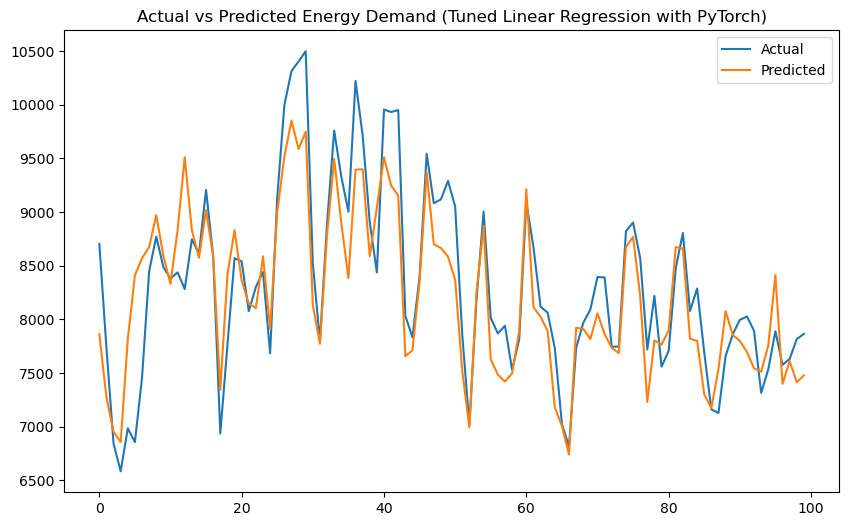

In [1]:
# -*- coding: utf-8 -*-
"""
Energy Demand Prediction Model (Linear Regression with PyTorch, Tuned)

Author: Manoj
"""

import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score  # For RMSE and R²
import os

# Step 1: Load Preprocessed Data
data_path = '../data/NSW/data_for_ml.csv'  # Update the path based on your file
preprocessed_data = pd.read_csv(data_path)


preprocessed_data.head()

# Step 2: Check for missing or infinite values in the dataset
def check_data_issues(data, columns):
    for col in columns:
        print(f"Checking column: {col}")
        missing_vals = data[col].isnull().sum()
        infinite_vals = np.isinf(data[col]).sum()
        print(f"Missing values: {missing_vals}, Infinite values: {infinite_vals}")
        if missing_vals > 0 or infinite_vals > 0:
            print(f"Column '{col}' contains issues and should be handled.")

columns_to_check = [
    'mean_temp', 'SOI','SST_DIFF','mean_humidity', 'mean_windspeed', 'TOTALDEMAND',
   'mean_solar_radiation', 'mean_wind_direction', 'rainfall', 'Population','DAYOFWEEK','DAYOFYEAR'
]
check_data_issues(preprocessed_data, columns_to_check)

# Step 3: Prepare data for PyTorch model training
# Use all relevant features for prediction
features = [
    'mean_temp', 'SOI','SST_DIFF','mean_humidity', 'mean_windspeed',  'mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population','DAYOFWEEK','DAYOFYEAR'
]
X = preprocessed_data[features].values
y = preprocessed_data['TOTALDEMAND'].values

# Step 4: Normalize the data to stabilize training
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 5: Split the data into training and test sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Step 6: Move data to GPU or CPU using PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to tensors and move to the chosen device (CPU or GPU)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# Step 7: Define the PyTorch Linear Regression Model with Dropout and extra layers
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)  # Increased units
        self.layer2 = nn.Linear(256, 128)  # Added complexity
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)  # Increased dropout

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

# Step 8: Initialize model, optimizer, and loss function with weight decay (L2 regularization)
model = LinearRegressionModel(X_train_tensor.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add L2 regularization
loss_fn = nn.MSELoss()

# Step 9: Initialize weights using Xavier initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

model.apply(init_weights)

# Step 10: Train the model with increased epochs, mini-batch gradient descent, and scheduler
def train_model(model, X_train, y_train, optimizer, loss_fn, batch_size=64, epochs=500):
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Reduce learning rate every 50 epochs
    
    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()  # Update the learning rate
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

train_model(model, X_train_tensor, y_train_tensor, optimizer, loss_fn, epochs=500)

# Step 11: Save the model
model_save_path = '../data/NSW/saved_model.pth'  # Define where to save the model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Step 12: Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor)
    y_pred_test = model(X_test_tensor)

    # Calculate Train and Test MSE
    train_mse = loss_fn(y_pred_train, y_train_tensor).item()
    test_mse = loss_fn(y_pred_test, y_test_tensor).item()
    
    # Calculate RMSE (Root Mean Squared Error)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    
    # Convert predictions and actual values to CPU numpy arrays
    y_train_cpu = y_train_tensor.cpu().numpy()
    y_test_cpu = y_test_tensor.cpu().numpy()
    y_pred_train_cpu = y_pred_train.cpu().numpy()
    y_pred_test_cpu = y_pred_test.cpu().numpy()
    
    # Calculate R² (R-squared)
    train_r2 = r2_score(y_train_cpu, y_pred_train_cpu)
    test_r2 = r2_score(y_test_cpu, y_pred_test_cpu)

    # Print evaluation metrics
    print(f'Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R²: {train_r2}')
    print(f'Test MSE: {test_mse}, Test RMSE: {test_rmse}, Test R²: {test_r2}')

# Step 13: Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_tensor.cpu().numpy()[:100], label='Actual')
plt.plot(y_pred_test.cpu().numpy()[:100], label='Predicted')
plt.title('Actual vs Predicted Energy Demand (Tuned Linear Regression with PyTorch)')
plt.legend()
plt.show()


In [ ]:
Validate the Linear Regression Model

Using device: cpu
Epoch 0/500, Loss: 66742196.0
Epoch 10/500, Loss: 973189.8125
Epoch 20/500, Loss: 1146380.5
Epoch 30/500, Loss: 610227.8125
Epoch 40/500, Loss: 420610.6875
Epoch 50/500, Loss: 245880.96875
Epoch 60/500, Loss: 617185.375
Epoch 70/500, Loss: 462161.3125
Epoch 80/500, Loss: 713290.875
Epoch 90/500, Loss: 298992.5625
Epoch 100/500, Loss: 1134219.25
Epoch 110/500, Loss: 731105.625
Epoch 120/500, Loss: 886645.0
Epoch 130/500, Loss: 635334.5625
Epoch 140/500, Loss: 521120.84375
Epoch 150/500, Loss: 853827.3125
Epoch 160/500, Loss: 796890.625
Epoch 170/500, Loss: 294490.28125
Epoch 180/500, Loss: 441302.6875
Epoch 190/500, Loss: 368051.53125
Epoch 200/500, Loss: 912883.375
Epoch 210/500, Loss: 682773.625
Epoch 220/500, Loss: 564677.5
Epoch 230/500, Loss: 457635.90625
Epoch 240/500, Loss: 301269.25
Epoch 250/500, Loss: 802873.5
Epoch 260/500, Loss: 402101.71875
Epoch 270/500, Loss: 558427.25
Epoch 280/500, Loss: 1093030.5
Epoch 290/500, Loss: 671853.9375
Epoch 300/500, Loss: 1

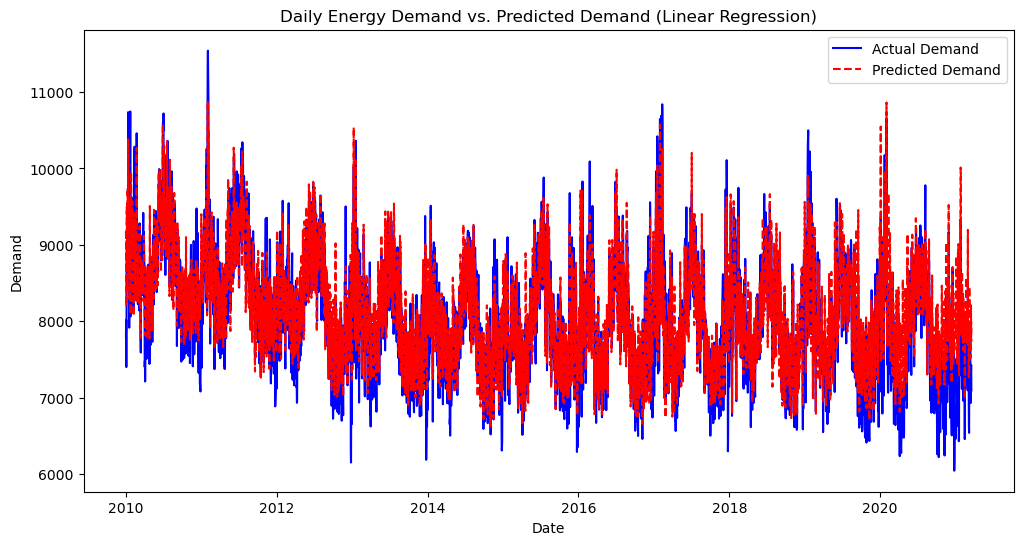

In [2]:
# -*- coding: utf-8 -*-
"""
Energy Demand Prediction Model (Linear Regression with PyTorch, Tuned)

Author: Manoj
"""

import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load Preprocessed Data
def load_and_aggregate_data():
    data_path = '../data/NSW/data_for_ml.csv'  # Update the path based on your file
    daily_data = pd.read_csv(data_path)
    daily_data['Date'] = pd.to_datetime(daily_data['Date'])
    daily_data['Year'] = daily_data['Date'].dt.year
    daily_data['Month'] = daily_data['Date'].dt.month
    daily_data['Week'] = daily_data['Date'].dt.isocalendar().week
    return daily_data

# Step 2: Prepare data for PyTorch model training
def prepare_data_for_training(data):
    features = [
        'mean_temp','SOI','SST_DIFF', 'mean_humidity', 'mean_windspeed', 'mean_solar_radiation',
        'mean_wind_direction', 'rainfall', 'Population', 'DAYOFWEEK', 'DAYOFYEAR'
    ]
    X = data[features].values
    y = data['TOTALDEMAND'].values

    # Normalize the data to stabilize training
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Split the data into training and test sets
    split_index = int(len(X) * 0.8)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    return X_train, X_test, y_train, y_test, scaler

# Step 3: Move data to GPU or CPU using PyTorch
def move_data_to_device(X_train, X_test, y_train, y_test):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Convert data to tensors and move to the chosen device (CPU or GPU)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, device

# Step 4: Define the PyTorch Linear Regression Model with Dropout and extra layers
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)  # Increased units
        self.layer2 = nn.Linear(256, 128)  # Added complexity
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)  # Increased dropout

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

# Step 5: Initialize model, optimizer, and loss function with weight decay (L2 regularization)
def init_model(input_dim, device):
    model = LinearRegressionModel(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add L2 regularization
    loss_fn = nn.MSELoss()

    # Initialize weights using Xavier initialization
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
    model.apply(init_weights)

    return model, optimizer, loss_fn

# Step 6: Train the model
def train_model(model, X_train, y_train, optimizer, loss_fn, batch_size=64, epochs=500):
    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Reduce learning rate every 50 epochs

    model.train()
    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()
        scheduler.step()  # Update the learning rate
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {loss.item()}')

# Step 7: Evaluate the model and plot the results
def evaluate_and_plot(model, X_test_tensor, y_test_tensor, daily_data, scaler, device):
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor).cpu().numpy()

        # Predict on full dataset
        X_full = scaler.transform(daily_data[['mean_temp','SOI','SST_DIFF', 'mean_humidity', 'mean_windspeed',
                                               'mean_solar_radiation', 'mean_wind_direction',
                                              'rainfall', 'Population', 'DAYOFWEEK', 'DAYOFYEAR']].values)
        X_full_tensor = torch.tensor(X_full, dtype=torch.float32).to(device)
        y_pred_full = model(X_full_tensor).cpu().numpy()

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data['Date'], daily_data['TOTALDEMAND'], label='Actual Demand', color='blue')
    plt.plot(daily_data['Date'], y_pred_full, label='Predicted Demand', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title('Daily Energy Demand vs. Predicted Demand (Linear Regression)')
    plt.legend()
    plt.show()

# Step 8: Main function
def main():
    # Load and preprocess the data
    daily_data = load_and_aggregate_data()

    # Prepare data for training
    X_train, X_test, y_train, y_test, scaler = prepare_data_for_training(daily_data)
    X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor, device = move_data_to_device(X_train, X_test, y_train, y_test)

    # Initialize and train the model
    model, optimizer, loss_fn = init_model(X_train_tensor.shape[1], device)
    train_model(model, X_train_tensor, y_train_tensor, optimizer, loss_fn, epochs=500)

    # Evaluate the model and plot the results
    evaluate_and_plot(model, X_test_tensor, y_test_tensor, daily_data, scaler, device)

if __name__ == '__main__':
    main()



Predict future demand using Regression Model

Using device: cpu
Demand forecasts saved successfully to CSV files.


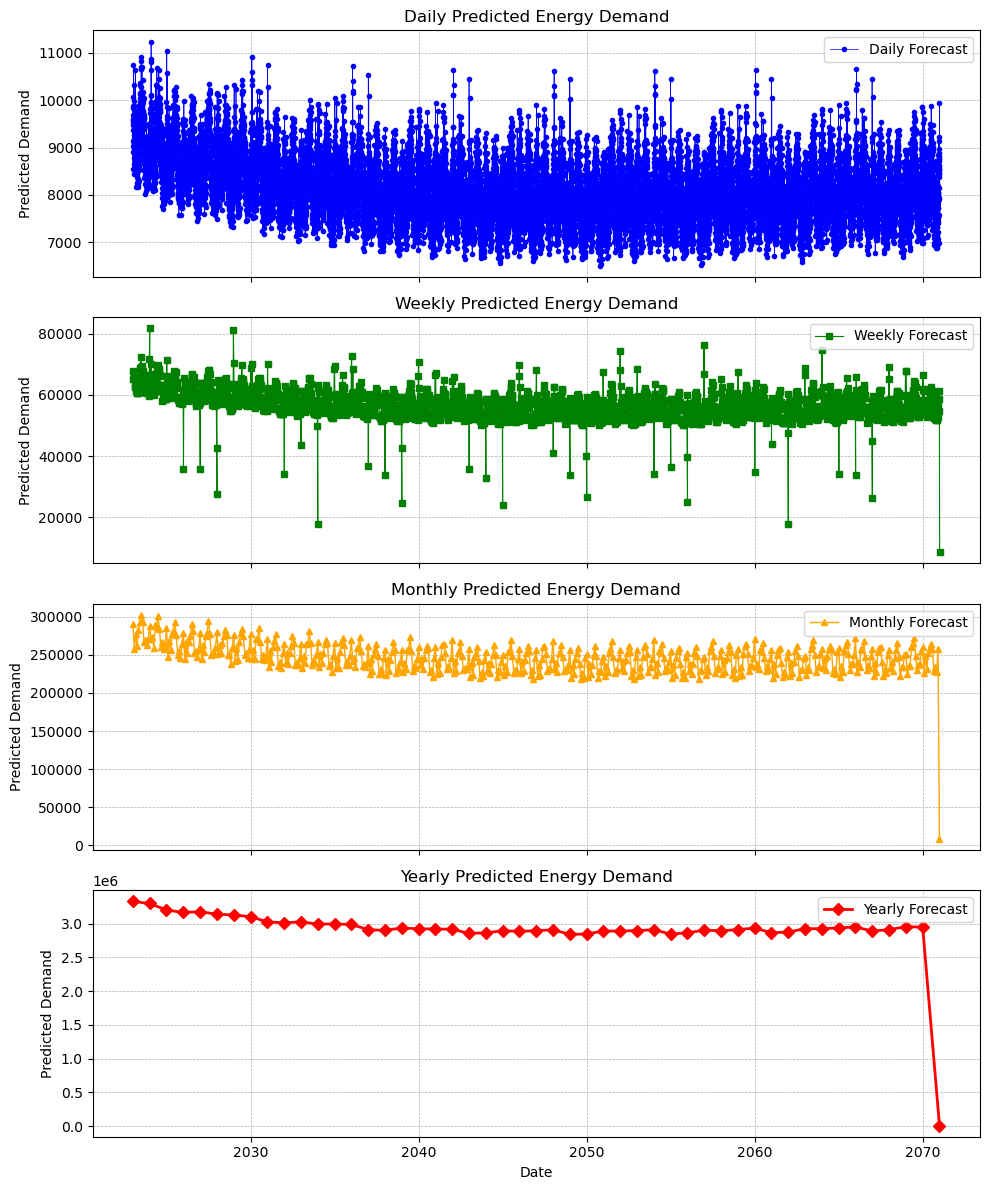

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import os

# Step 1: Load Population Forecasts and rename 'Population_Pred' to 'Population'
population_forecast_daily = pd.read_csv('../data/Population/population_forecast_with_features_daily.csv')

# Rename 'Population_Pred' to 'Population'
population_forecast_daily.rename(columns={'Population_Pred': 'Population'}, inplace=True)
population_forecast_daily['Date'] = pd.to_datetime(population_forecast_daily['Date'])  # Convert 'Date' column to datetime

# Extract 'Year', 'Month', 'Week' from the 'Date' for aggregation purposes
population_forecast_daily['Year'] = population_forecast_daily['Date'].dt.year
population_forecast_daily['Month'] = population_forecast_daily['Date'].dt.month
population_forecast_daily['Week'] = population_forecast_daily['Date'].dt.isocalendar().week

# Features for the model
features = [
    'mean_temp', 'SOI','SST_DIFF','mean_humidity', 'mean_windspeed',  'mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population', 'DAYOFWEEK', 'DAYOFYEAR'
]

# Step 2: Prepare data for PyTorch model training
def prepare_forecast_data(population_forecast, features):
    X = population_forecast[features].values
    return X

# Prepare daily data
X_daily = prepare_forecast_data(population_forecast_daily, features)

# Step 3: Normalize the data
scaler = StandardScaler()
X_daily = scaler.fit_transform(X_daily)

# Step 4: Move data to GPU or CPU using PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to tensors and move to the chosen device (CPU or GPU)
X_daily_tensor = torch.tensor(X_daily, dtype=torch.float32).to(device)

# Step 5: Define the PyTorch Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 256)  # Increased units
        self.layer2 = nn.Linear(256, 128)  # Added complexity
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.3)  # Increased dropout

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout(x)
        x = torch.relu(self.layer3(x))
        return self.layer4(x)

# Step 6: Load the saved Linear Regression model
model = LinearRegressionModel(X_daily_tensor.shape[1]).to(device)
model_path = '../data/NSW/saved_model.pth'  # Define where your model is saved
model.load_state_dict(torch.load(model_path))
model.eval()

# Step 7: Make predictions for daily data
with torch.no_grad():
    y_pred_daily = model(X_daily_tensor).cpu().numpy().flatten()

# Assign predicted values to DataFrame
population_forecast_daily['Predicted_Demand'] = y_pred_daily

# Step 8: Aggregate the daily predictions to weekly, monthly, and yearly
population_forecast_weekly = population_forecast_daily.groupby(['Year', 'Week'], as_index=False).agg({'Predicted_Demand': 'sum'})
population_forecast_monthly = population_forecast_daily.groupby(['Year', 'Month'], as_index=False).agg({'Predicted_Demand': 'sum'})
population_forecast_yearly = population_forecast_daily.groupby(['Year'], as_index=False).agg({'Predicted_Demand': 'sum'})

# Create a date column for weekly data
population_forecast_weekly['Date'] = population_forecast_weekly.apply(lambda row: pd.to_datetime(f'{int(row["Year"])}-{int(row["Week"])}-1', format='%Y-%W-%w'), axis=1)

# Create a date column for monthly data
population_forecast_monthly['Date'] = population_forecast_monthly.apply(lambda row: pd.to_datetime(f'{int(row["Year"])}-{int(row["Month"])}-01'), axis=1)

# Use the first day of the year for yearly data
population_forecast_yearly['Date'] = population_forecast_yearly['Year'].apply(lambda year: pd.to_datetime(f'{int(year)}-01-01'))

# Step 9: Save the forecast results to CSV
population_forecast_daily.to_csv('../data/NSW/daily_demand_forecast_LR.csv', index=False)
population_forecast_weekly.to_csv('../data/NSW/weekly_demand_forecast_LR.csv', index=False)
population_forecast_monthly.to_csv('../data/NSW/monthly_demand_forecast_LR.csv', index=False)
population_forecast_yearly.to_csv('../data/NSW/yearly_demand_forecast_LR.csv', index=False)

print("Demand forecasts saved successfully to CSV files.")

# Step 10: Visualization - Subplots for Daily, Weekly, and Monthly Forecasts

fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Adjust line width and marker styles for better visualization
ax[0].plot(population_forecast_daily['Date'], population_forecast_daily['Predicted_Demand'], label='Daily Forecast', color='blue', linewidth=0.5, marker='o', markersize=3)
ax[0].set_title('Daily Predicted Energy Demand')
ax[0].set_ylabel('Predicted Demand')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].legend()

ax[1].plot(population_forecast_weekly['Date'], population_forecast_weekly['Predicted_Demand'], label='Weekly Forecast', color='green', linewidth=0.8, marker='s', markersize=4)
ax[1].set_title('Weekly Predicted Energy Demand')
ax[1].set_ylabel('Predicted Demand')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].legend()

ax[2].plot(population_forecast_monthly['Date'], population_forecast_monthly['Predicted_Demand'], label='Monthly Forecast', color='orange', linewidth=1, marker='^', markersize=5)
ax[2].set_title('Monthly Predicted Energy Demand')
ax[2].set_ylabel('Predicted Demand')
ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[2].legend()

ax[3].plot(population_forecast_yearly['Date'], population_forecast_yearly['Predicted_Demand'], label='Yearly Forecast', color='red', linewidth=2, marker='D', markersize=6)
ax[3].set_title('Yearly Predicted Energy Demand')
ax[3].set_ylabel('Predicted Demand')
ax[3].set_xlabel('Date')
ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[3].legend()

# Improve layout and show the plot
plt.tight_layout()
plt.show()


Random Forest Model

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': None}
Train RMSE: 88.29024057670489, Train R²: 0.9877964542438553
Test RMSE: 238.6092350924638, Test R²: 0.9102840497119034
Tuned Random Forest model saved to ../data/NSW/saved_tuned_rf_model.pkl


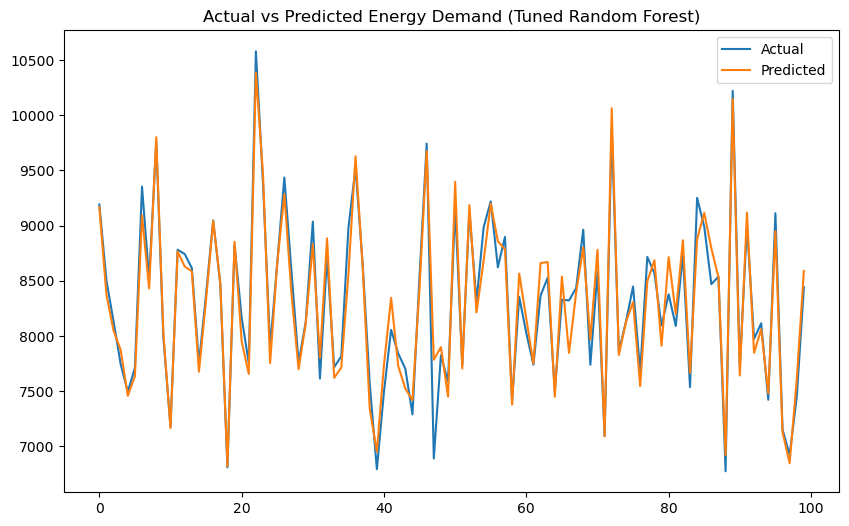

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import torch
import pickle

# Step 1: Load Preprocessed Data
data_path = '../data/NSW/data_for_ml.csv'  # Update the path based on your file
preprocessed_data = pd.read_csv(data_path)

# Step 2: Prepare data
features = [
    'mean_temp', 'SOI','SST_DIFF','mean_humidity', 'mean_windspeed', 'mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population','DAYOFWEEK','DAYOFYEAR'
]
X = preprocessed_data[features].values
y = preprocessed_data['TOTALDEMAND'].values

# Step 3: Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Step 4: Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Step 6: Define hyperparameter grid
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'sqrt', 'log2']  # Remove 'auto', use 1.0 as default or other options
}


# Step 7: Perform RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, 
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Step 8: Get the best parameters
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Step 9: Train the Random Forest model with the best parameters
best_rf = random_search.best_estimator_

# Step 10: Make predictions and evaluate the model
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Calculate Train and Test RMSE and R²
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

# Print the results
print(f"Train RMSE: {train_rmse}, Train R²: {train_r2}")
print(f"Test RMSE: {test_rmse}, Test R²: {test_r2}")

# Step 11: Save the tuned model
model_save_path = '../data/NSW/saved_tuned_rf_model.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(best_rf, f)
print(f"Tuned Random Forest model saved to {model_save_path}")

# Step 12: Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred_test[:100], label='Predicted')
plt.title('Actual vs Predicted Energy Demand (Tuned Random Forest)')
plt.legend()
plt.show()


Validate the Random Forest Model

Checking columns and missing values in datasets:

daily_data columns: Index(['Date', 'mean_humidity', 'SOI', 'SST_DIFF', 'mean_solar_radiation',
       'mean_temp', 'mean_wind_direction', 'mean_windspeed', 'rainfall',
       'Population', 'TOTALDEMAND', 'DAYOFWEEK', 'DAYOFYEAR', 'Year', 'Month',
       'Week'],
      dtype='object')
daily_data TOTALDEMAND missing values count: 0
daily_data TOTALDEMAND unique values: [7801.35291667 8017.45979167 7399.89958333 ... 7330.37520833 7428.18791667
 7094.51      ]
First few rows of daily_data:
        Date  mean_humidity    SOI  SST_DIFF  mean_solar_radiation  mean_temp  \
0 2010-01-01      71.304348  11.17      1.59            187.700000  23.836522   
1 2010-01-02      76.874167   8.91      1.59            213.191667  23.453333   
2 2010-01-03      85.810000   4.48      1.59             73.622917  17.603333   
3 2010-01-04      80.723333  14.09      1.55            125.110417  18.863333   
4 2010-01-05      67.842500  11.69      1.55          

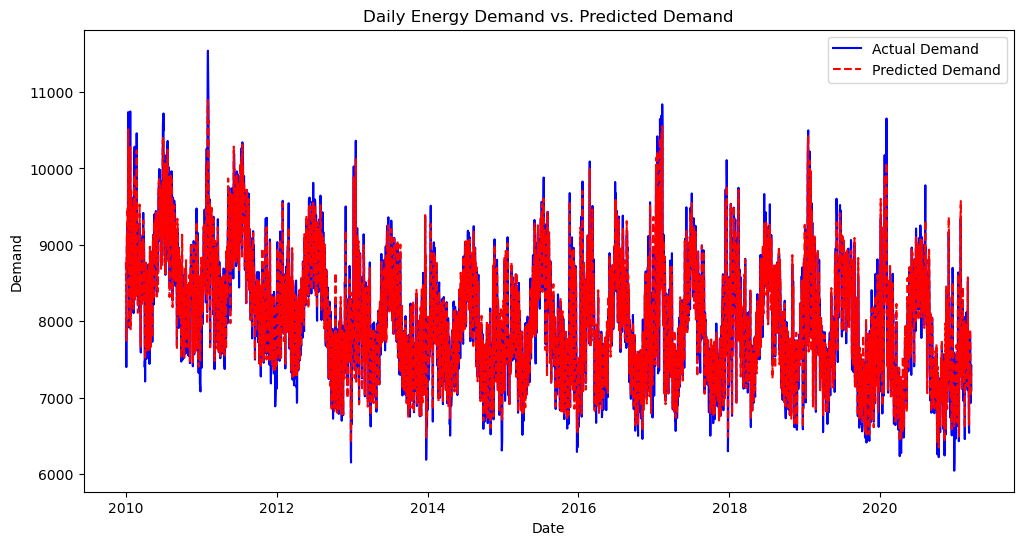

In [5]:
# -*- coding: utf-8 -*-
"""
Energy Demand Prediction Model (Random Forest with Aggregated Predictions)

Author: Manoj
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt

# Step 1: Load Data
def load_and_aggregate_data():
    daily_data = pd.read_csv('../data/NSW/data_for_ml.csv')
    daily_data['Date'] = pd.to_datetime(daily_data['Date'])
    daily_data['Year'] = daily_data['Date'].dt.year
    daily_data['Month'] = daily_data['Date'].dt.month
    daily_data['Week'] = daily_data['Date'].dt.isocalendar().week
    
    # Aggregate features
    daily_aggregated = daily_data.groupby('Date').mean(numeric_only=True).reset_index()
    weekly_aggregated = daily_data.groupby(['Year', 'Week']).mean(numeric_only=True).reset_index()
    monthly_aggregated = daily_data.groupby(['Year', 'Month']).mean(numeric_only=True).reset_index()
    yearly_aggregated = daily_data.groupby('Year').mean(numeric_only=True).reset_index()
    
    return daily_data, daily_aggregated, weekly_aggregated, monthly_aggregated, yearly_aggregated

# Step 2: Fill Missing Feature Data
def fill_missing_values(data, feature_columns):
    for col in feature_columns:
        if col in data.columns and data[col].isnull().sum() > 0:
            data[col] = data[col].fillna(data[col].mean())  # Fill with mean

# Step 3: Normalize Features
def normalize_features(data, features, scaler=None):
    X = data[features].values
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

# Step 4: Main Execution
def main():
    # Load datasets
    daily_data, daily_aggregated, weekly_aggregated, monthly_aggregated, yearly_aggregated = load_and_aggregate_data()
    
    # Debugging: Print column names and missing value info
    print("Checking columns and missing values in datasets:")
    datasets = {'daily_data': daily_data, 'weekly_data': weekly_aggregated, 'monthly_data': monthly_aggregated, 'yearly_data': yearly_aggregated}
    for name, dataset in datasets.items():
        print(f"\n{name} columns: {dataset.columns}")
        print(f"{name} TOTALDEMAND missing values count: {dataset['TOTALDEMAND'].isnull().sum() if 'TOTALDEMAND' in dataset.columns else 'N/A'}")
        print(f"{name} TOTALDEMAND unique values: {dataset['TOTALDEMAND'].unique() if 'TOTALDEMAND' in dataset.columns else 'N/A'}")
        print(f"First few rows of {name}:\n{dataset.head()}")

    # Check for missing TOTALDEMAND values and handle them
    for name, dataset in datasets.items():
        if 'TOTALDEMAND' in dataset.columns:
            if dataset['TOTALDEMAND'].isnull().all():
                raise ValueError(f"TOTALDEMAND column is entirely NaN in {name}!")

    # Fill missing values for features
    feature_columns = ['mean_temp', 'SOI','SST_DIFF','mean_humidity', 'mean_windspeed','mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population','DAYOFWEEK','DAYOFYEAR']
    fill_missing_values(daily_data, feature_columns)
    fill_missing_values(weekly_aggregated, feature_columns)
    fill_missing_values(monthly_aggregated, feature_columns)
    fill_missing_values(yearly_aggregated, feature_columns)
    
    # Handle missing TOTALDEMAND values
    if 'TOTALDEMAND' in daily_data.columns:
        daily_data['TOTALDEMAND'] = daily_data['TOTALDEMAND'].ffill().bfill()
        missing_values_count = daily_data['TOTALDEMAND'].isnull().sum()
        total_rows = len(daily_data)
        print(f"Found {missing_values_count} missing values in TOTALDEMAND out of {total_rows} rows.")
        
        if missing_values_count > 0:
            print("Removing rows with missing TOTALDEMAND values.")
            daily_data = daily_data.dropna(subset=['TOTALDEMAND'])
        
        if daily_data.empty:
            raise ValueError("The dataset is empty after handling TOTALDEMAND values. Check your data preprocessing.")
    
    # Normalize features
    features = ['mean_temp','SOI','SST_DIFF', 'mean_humidity', 'mean_windspeed','mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population','DAYOFWEEK','DAYOFYEAR']
    
    X_daily, scaler = normalize_features(daily_data, features)
    X_yearly, scaler = normalize_features(yearly_aggregated, features, scaler)
    X_monthly, _ = normalize_features(monthly_aggregated, features, scaler)
    X_weekly, _ = normalize_features(weekly_aggregated, features, scaler)
    
    # Define and train the Random Forest model
    rf = RandomForestRegressor(random_state=42)
    param_distributions = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': [1.0, 'sqrt', 'log2']
    }
    
    random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, 
                                       n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
    random_search.fit(X_daily, daily_data['TOTALDEMAND'])
    
    best_rf = random_search.best_estimator_
    
    # Save the trained model
    model_save_path = '../data/NSW/saved_tuned_rf_model.pkl'
    with open(model_save_path, 'wb') as f:
        pickle.dump(best_rf, f)
    print(f"Tuned Random Forest model saved to {model_save_path}")
    
    # Predict for daily, weekly, monthly, and yearly demand
    y_pred_daily = best_rf.predict(X_daily)
    y_pred_weekly = best_rf.predict(X_weekly)
    y_pred_monthly = best_rf.predict(X_monthly)
    y_pred_yearly = best_rf.predict(X_yearly)
    
    # Aggregate Daily Predictions
    daily_data['Predicted_Demand'] = y_pred_daily
    aggregated_daily_weekly = daily_data.groupby(['Year', 'Week']).sum(numeric_only=True)['Predicted_Demand'].reset_index()
    aggregated_daily_monthly = daily_data.groupby(['Year', 'Month']).sum(numeric_only=True)['Predicted_Demand'].reset_index()
    aggregated_daily_yearly = daily_data.groupby('Year').sum(numeric_only=True)['Predicted_Demand'].reset_index()
    
    # Combine Predictions
    def combine_predictions(data, aggregated_data, predictions, time_period):
        result = data[[time_period]].copy()
        result['Predicted_Demand'] = predictions
        result['Aggregated_Daily_Predicted_Demand'] = aggregated_data['Predicted_Demand']
        return result
    
    yearly_results = combine_predictions(yearly_aggregated, aggregated_daily_yearly, y_pred_yearly, 'Year')
    monthly_results = combine_predictions(monthly_aggregated, aggregated_daily_monthly, y_pred_monthly, 'Month')
    weekly_results = combine_predictions(weekly_aggregated, aggregated_daily_weekly, y_pred_weekly, 'Week')
    daily_results = daily_data[['Date', 'TOTALDEMAND', 'Predicted_Demand']].copy()

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(daily_data['Date'], daily_data['TOTALDEMAND'], label='Actual Demand', color='blue')
    plt.plot(daily_data['Date'], daily_data['Predicted_Demand'], label='Predicted Demand', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.title('Daily Energy Demand vs. Predicted Demand')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main()


Predict future demand using Random Forest Model

Demand forecasts saved successfully to CSV files.


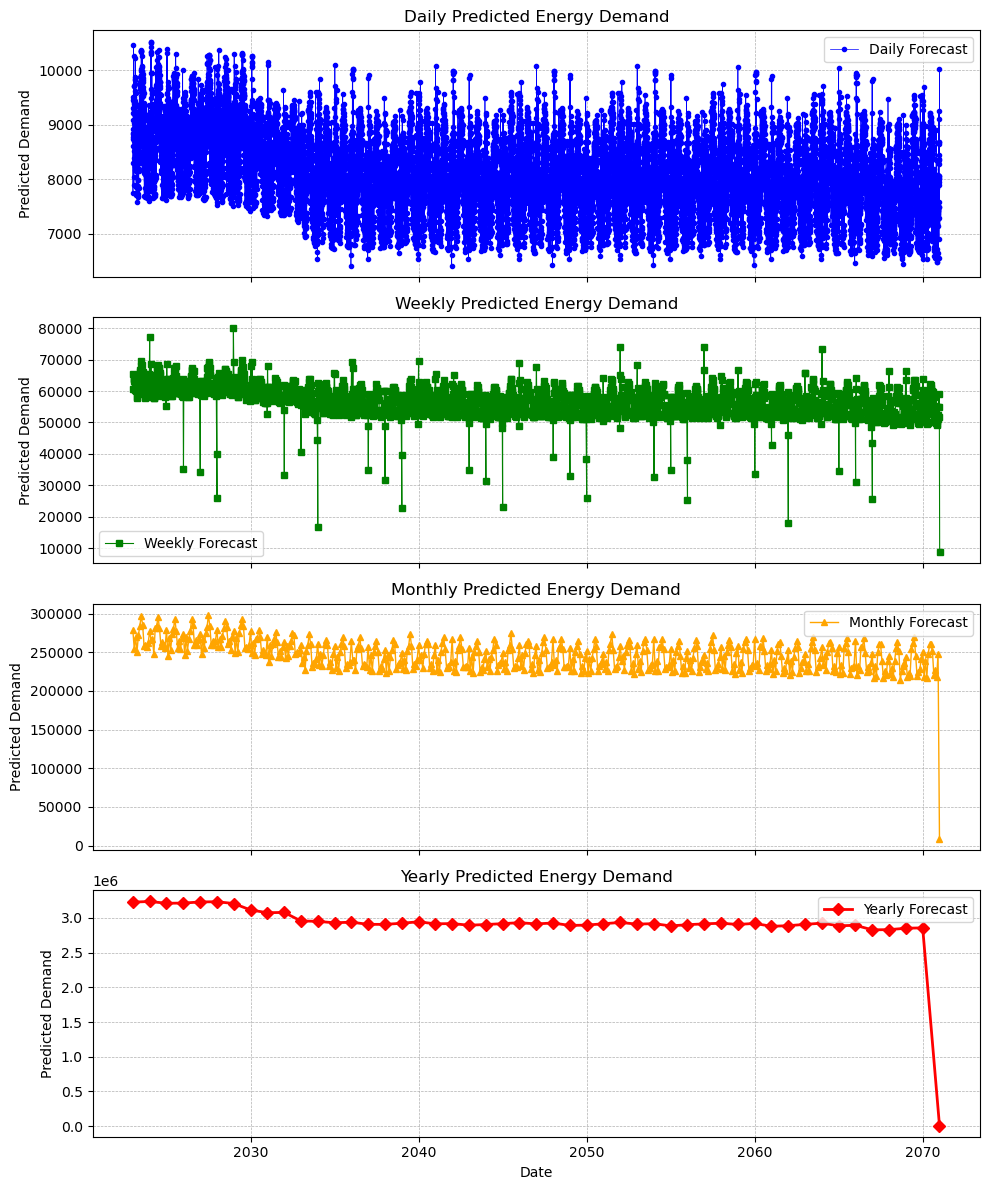

In [6]:
# -*- coding: utf-8 -*-
"""
Energy Demand Prediction Model (Random Forest with Aggregated Predictions)

Author: Manoj
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt

# Step 1: Load Population Forecasts and rename 'Population_Pred' to 'Population'
population_forecast_daily = pd.read_csv('../data/Population/population_forecast_with_features_daily.csv')

# Rename 'Population_Pred' to 'Population'
population_forecast_daily.rename(columns={'Population_Pred': 'Population'}, inplace=True)
population_forecast_daily['Date'] = pd.to_datetime(population_forecast_daily['Date'])  # Convert 'Date' column to datetime

# Extract 'Year', 'Month', 'Week' from the 'Date' for aggregation purposes
population_forecast_daily['Year'] = population_forecast_daily['Date'].dt.year
population_forecast_daily['Month'] = population_forecast_daily['Date'].dt.month
population_forecast_daily['Week'] = population_forecast_daily['Date'].dt.isocalendar().week

# Features for the model
features = [
    'mean_temp','SOI','SST_DIFF', 'mean_humidity', 'mean_windspeed', 'mean_solar_radiation',
    'mean_wind_direction', 'rainfall', 'Population', 'DAYOFWEEK', 'DAYOFYEAR'
]

# Step 2: Prepare data for Random Forest model prediction
def prepare_forecast_data(population_forecast, features):
    X = population_forecast[features].values
    return X

# Prepare daily data
X_daily = prepare_forecast_data(population_forecast_daily, features)

# Step 3: Normalize the data
scaler = StandardScaler()
X_daily = scaler.fit_transform(X_daily)

# Step 4: Load the saved Random Forest model
model_path = '../data/NSW/saved_tuned_rf_model.pkl'  # Define where the RF model is saved
with open(model_path, 'rb') as f:
    best_rf = pickle.load(f)

# Step 5: Make predictions for daily data
y_pred_daily = best_rf.predict(X_daily)

# Assign predicted values to DataFrame
population_forecast_daily['Predicted_Demand'] = y_pred_daily

# Step 6: Aggregate the daily predictions to weekly, monthly, and yearly
population_forecast_weekly = population_forecast_daily.groupby(['Year', 'Week'], as_index=False).agg({'Predicted_Demand': 'sum'})
population_forecast_monthly = population_forecast_daily.groupby(['Year', 'Month'], as_index=False).agg({'Predicted_Demand': 'sum'})
population_forecast_yearly = population_forecast_daily.groupby(['Year'], as_index=False).agg({'Predicted_Demand': 'sum'})

# Create a date column for weekly data
population_forecast_weekly['Date'] = population_forecast_weekly.apply(lambda row: pd.to_datetime(f'{int(row["Year"])}-{int(row["Week"])}-1', format='%Y-%W-%w'), axis=1)

# Create a date column for monthly data
population_forecast_monthly['Date'] = population_forecast_monthly.apply(lambda row: pd.to_datetime(f'{int(row["Year"])}-{int(row["Month"])}-01'), axis=1)

# Use the first day of the year for yearly data
population_forecast_yearly['Date'] = population_forecast_yearly['Year'].apply(lambda year: pd.to_datetime(f'{int(year)}-01-01'))

# Step 7: Save the forecast results to CSV
population_forecast_daily.to_csv('../data/NSW/daily_demand_forecastRF.csv', index=False)
population_forecast_weekly.to_csv('../data/NSW/weekly_demand_forecastRF.csv', index=False)
population_forecast_monthly.to_csv('../data/NSW/monthly_demand_forecastRF.csv', index=False)
population_forecast_yearly.to_csv('../data/NSW/yearly_demand_forecastRF.csv', index=False)

print("Demand forecasts saved successfully to CSV files.")

# Step 8: Visualization - Subplots for Daily, Weekly, Monthly, and Yearly Forecasts

fig, ax = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Adjust line width and marker styles for better visualization
ax[0].plot(population_forecast_daily['Date'], population_forecast_daily['Predicted_Demand'], label='Daily Forecast', color='blue', linewidth=0.5, marker='o', markersize=3)
ax[0].set_title('Daily Predicted Energy Demand')
ax[0].set_ylabel('Predicted Demand')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[0].legend()

ax[1].plot(population_forecast_weekly['Date'], population_forecast_weekly['Predicted_Demand'], label='Weekly Forecast', color='green', linewidth=0.8, marker='s', markersize=4)
ax[1].set_title('Weekly Predicted Energy Demand')
ax[1].set_ylabel('Predicted Demand')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[1].legend()

ax[2].plot(population_forecast_monthly['Date'], population_forecast_monthly['Predicted_Demand'], label='Monthly Forecast', color='orange', linewidth=1, marker='^', markersize=5)
ax[2].set_title('Monthly Predicted Energy Demand')
ax[2].set_ylabel('Predicted Demand')
ax[2].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[2].legend()

ax[3].plot(population_forecast_yearly['Date'], population_forecast_yearly['Predicted_Demand'], label='Yearly Forecast', color='red', linewidth=2, marker='D', markersize=6)
ax[3].set_title('Yearly Predicted Energy Demand')
ax[3].set_ylabel('Predicted Demand')
ax[3].set_xlabel('Date')
ax[3].grid(True, which='both', linestyle='--', linewidth=0.5)
ax[3].legend()

# Improve layout and show the plot
plt.tight_layout()
plt.show()
